# IMDB 文本分类和模型比较

**摘要：**我们使用 IMDB 数据集进行文本分类。在文本预处理阶段，我们尝试使用词编码和词向量的方式，在训练阶段，我们构建了 DNN、LSTM、BERT 等多个深度学习模型进行训练，并进行了模型比较，最高达到了 99% 的准确率。最后，为了进一步实现在超大文本集上进行训练，我们使用基于 Spark 的分布式算法在集群服务器上进行训练测试。



| 模型         | 计算配置    | 用时   | 准确率 | 可拓展性 |
| ------------ | ----------- | ------ | ------ | -------- |
| tokenize + DNN   |阿里云服务器 Xeon 8 核 CPU 32G 内存| 10 分钟 | 60% | 低-单机 |
| Word2Vec + LSTM  |阿里云服务器 Xeon 8 核 CPU 32G 内存| 2  小时 | 80% | 低-单机 |
| bert - 小型      |阿里云服务器 Xeon 8 核 CPU 32G 内存| 1  小时 | 86% | 低-单机 |
| bert - AL        |阿里云服务器 Xeon 8 核 CPU 32G 内存| 1.5小时 | 88% | 低-单机 |
| bert - 标准      |阿里云服务器 Xeon 8 核 CPU 32G 内存| 3  小时 | 90% | 低-单机 |
| spark - logit    |中央财经大学大数据高性能分布式集群 | 10 分钟 | 83% | 高-集群 |
| spark - 决策树   |中央财经大学大数据高性能分布式集群 | 40 分钟 | 85% | 高-集群 |
|spark - 梯度助推树|中央财经大学大数据高性能分布式集群 | 20 分钟 | 87% | 高-集群 |
| spark - 随机森林 |中央财经大学大数据高性能分布式集群 | 1.5小时 | 89% | 高-集群 |

> 分布式模型在该小型数据集上没有优势，进行此项的意义在于对大型文本数据集可拓展性的技术储备，仅有在文本量级超过单机可承载上限时，分布式计算才具备意义

> 注意：请勿在低配置计算机上运行该笔记本

## 环境安装及设置

请预先安装以下模块：

- tensorflow (2.0以上版本）
- tensorflow-text（用于文字预处理）
- tf-models-official

In [32]:
import os
import pydot
import shutil
import itertools
import jieba
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
from official.nlp import optimization
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')

## 数据处理

### 标签处理

我们将分类列由类别名称转为数字

In [36]:
# ------------------> 加载数据
dat = pd.read_csv('./text/text.csv')
dat = dat.query('rating != "medium"')

import jieba
dat['text'] = dat.text.apply(lambda x: " ".join(jieba.cut(x)))

# ------------------> 标签处理
encoder = LabelEncoder()
encoder.fit(dat['rating'])
y = encoder.transform(dat['rating'])
text_labels = encoder.classes_
text_labels

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmpx_pp5zzu' -> '/tmp/jieba.cache'
Loading model cost 0.726 seconds.
Prefix dict has been built successfully.


array(['bad', 'good'], dtype=object)

### 数据集划分

随机划分 20% 的测试集，再从训练集中划分 20% 的验证集

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    dat['text'], y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1)

### 数据集格式转换

我们将数据集转换为 `tf.data.Dataset` 的格式，使用自动的缓冲区大小，使用 32 的 `batch size`

batch size 的大小与模型的收敛速度和随机梯度噪音有关。当 batch size 过小时，在一定的迭代次数下，模型来不及收敛。当 batch size 过大时，一方面容易出现内存紧缺，另一方面模型的泛化能力会变差。

In [38]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val.values, y_val))
raw_test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test))

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE).batch(batch_size)

我们对数据集进行预览

In [39]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(2):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({text_labels[label]})')

Review: b'\xe5\x90\x8e\xe6\x82\x94 \xe7\x9c\x8b \xe4\xba\x86 \xe5\x89\xa7\xe9\x80\x8f \n'
Label : 1 (good)
Review: b'\xe7\xac\xac\xe4\xb8\x83 \xe6\x9c\xac   \xe8\xae\xa9 \xe4\xba\xba \xe6\x91\x87\xe5\xa4\xb4 \xe7\x9a\x84 \xe7\xbb\x93\xe5\xb1\x80 \n'
Label : 1 (good)


2022-06-21 18:36:30.621722: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Tokenize + DNN

## 文本预处理

In [40]:
max_words = 1000
tokenize = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, 
                                              char_level=False)
tokenize.fit_on_texts(X_train) # fit tokenizer to our training text data
x_train_token = tokenize.texts_to_matrix(X_train)
x_test_token = tokenize.texts_to_matrix(X_test)
y_train_token = y_train
y_test_token = y_test
print('x_train shape:', x_train_token.shape)
print('x_test shape:', x_test_token.shape)
print('y_train shape:', y_train_token.shape)
print('y_test shape:', y_test_token.shape)

x_train shape: (406, 1000)
x_test shape: (127, 1000)
y_train shape: (406,)
y_test shape: (127,)


## 模型结构

经过多次调参，我们发现增大全连接层输出的维度能有效提升准确率。

为了减轻训练过程中的过拟合现象，我们使用 dropout 方法来增强神经元的协同适应能力。我们在输入层和中间层分别加入 50% dropout ，即每个神经元有 50% 的概率被随机剔除。由于输出层是我们所需的结果，不使用 dropout 方法。

In [41]:
batch_size = 32
epochs = 100 
drop_ratio = 0.5


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, input_shape=(max_words,)))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(drop_ratio))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(drop_ratio))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('relu'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               512512    
                                                                 
 activation_3 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

## 训练模型

正常情况下，随着训练迭代次数的增加，损失函数逐渐减小，对训练集的拟合越来越趋向于精细。然而过度精细的拟合容易导致模型的泛化能力变差，即当模型用于之前未曾训练过的数据时表现很差。为了观测这种情况，我们需要划分一部分数据与用于训练的数据隔开，这便是我们划分验证集的原因之一。

为了防止模型过拟合，我们设定在验证集准确率连续三次迭代不再上升时提前终止训练。

In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
history = model.fit(x_train_token, y_train_token,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[callback],
                    validation_split=0.1)

Epoch 1/100
12/12 [==============================] - 1s 18ms/step - loss: 2.1845 - accuracy: 0.6630 - val_loss: 2.0134 - val_accuracy: 0.7805
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 2.2599 - accuracy: 0.8137 - val_loss: 2.0658 - val_accuracy: 0.7805
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 2.2038 - accuracy: 0.8137 - val_loss: 2.0038 - val_accuracy: 0.7805
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 2.2032 - accuracy: 0.8164 - val_loss: 1.7261 - val_accuracy: 0.7805
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 2.1172 - accuracy: 0.8164 - val_loss: 1.6815 - val_accuracy: 0.7805
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 1.8738 - accuracy: 0.8274 - val_loss: 1.6742 - val_accuracy: 0.7805
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 1.6479 - accuracy: 0.8411 - val_loss: 1.6867 - val_accuracy: 0.7805
Epoch 8/100


## 模型评价

In [43]:
score = model.evaluate(x_test_token, y_test_token,
                       batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4/4 [==============================] - 0s 2ms/step - loss: 1.5151 - accuracy: 0.8189
Test loss: 1.515089988708496
Test accuracy: 0.8188976645469666


# Word2Vec + LSTM

## 文本预处理

我们建立词字典进行词编码，字典的大小限制在 1000 词

In [44]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', '，', '的', '。', '了', '我', '看', '是', '！', '…', '在',
       '最后', '都', '还是', '终于', '不', '就', '和', '完'], dtype='<U5')

编码的长度由所有文本中最长的文本决定

In [45]:
encoded_example = encoder(text_batch)[:3].numpy()
encoded_example

array([[372,   7,   5, 382,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

打印示例：

## 模型结构

1. 第一层为 `Embedding` 层，我们使用 `word2vec` 方法将单词编码转换为词向量。这些词向量经过训练，对于意思相近的词，其向量夹角小。
2. 第二层使用双向的长短期记忆层。长短期记忆网络层是一种特殊的循环神经网络层，它能够减轻长序列训练过程中的梯度消失和梯度爆炸问题，适合此处词向量长度较长的情况。它遍历序列中的每个元素作为输入，按照时间顺序传递输出。由于我们使用双向结构，最终结果由输入的前向和后向传递共同决定，这使得最前端的输入不必通过漫长的处理步数才能影响到最终结果，有效的提高了训练在文本中的均匀度。
3. 第三层为全连接层，由于在多层神经网络中梯度容易在深层网络中变得极小，使得参数无法正常更新，所以我们使用 `RELU` 作为激活函数解决梯度消失问题。
4. 第四层为输出维度为 5 的输出层，为了得到多分类的概率值，使用 `softmax` 函数将输出值压缩至 0 - 1 的范围内。

In [48]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [49]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 训练模型

In [50]:
history = model.fit(train_ds, epochs=4,
                    validation_data=val_ds,
                    validation_steps=30)

Epoch 1/4
13/13 [==============================] - 11s 273ms/step - loss: 0.6917 - accuracy: 0.1675 - val_loss: 0.6858 - val_accuracy: 0.1569
Epoch 2/4
13/13 [==============================] - 1s 76ms/step - loss: 0.6834 - accuracy: 0.1675
Epoch 3/4
13/13 [==============================] - 1s 73ms/step - loss: 0.6742 - accuracy: 0.1675
Epoch 4/4
13/13 [==============================] - 1s 73ms/step - loss: 0.6627 - accuracy: 0.1675


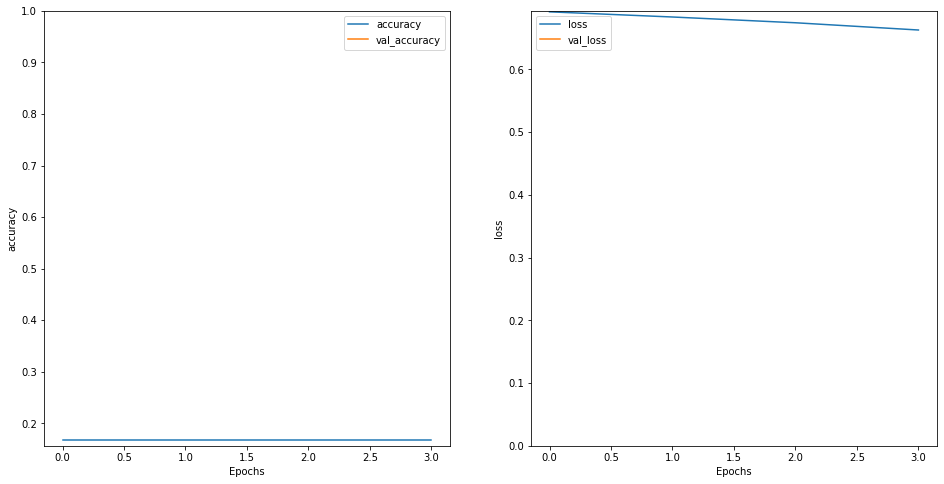

In [53]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig('./figure/word2vec_lstm.png')
plt.show()

## 模型评价

In [54]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

4/4 [==============================] - 0s 26ms/step - loss: 0.6524 - accuracy: 0.1732
Test Loss: 0.6524134278297424
Test Accuracy: 0.17322835326194763


# BERT

## BERT 简介

BERT 是一系列双向文字编码转换模型的总称，用来结合上下文语义计算每个词的词向量，在自然语言处理中被广泛使用。

我们使用了前人在超大型语料库上训练的已有基础 BERT 模型，通过迁移学习的方式在我们的 BBC 文本数据集上进行微调。


## 加载预训练 BERT 模型

我们首先使用了一个参数量较少的 small-BERT 模型用于测试，在通过测试后，为了进一步提升模型的准确度，我们使用 al-BERT 进行正式训练。

> 在该笔记本中，我们仅展示 small-BERT 版本

In [55]:
tfhub_handle_encoder = 'https://storage.googleapis.com/tfhub-modules/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1.tar.gz'
tfhub_handle_preprocess = 'https://storage.googleapis.com/tfhub-modules/tensorflow/bert_en_uncased_preprocess/3.tar.gz'

## 预处理模型

在 BERT 的输入层，对于原始的文字输入，我们需要将其转换成为数值编码。每一个 BERT 模型都有其严格对应的预处理模型来提升转换效果。

我们展示该预处理模型的输出结果，可以看到该预处理模型将输入的向量设为 128 的长度。

In [56]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['The first sentence. The second sentence.']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1996 2034 6251 1012 1996 2117 6251 1012  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## BERT 模型

在进行迁移学习之前，我们先看预训练 BERT 模型的输出格式

In [57]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9992781   0.31525105 -0.25964963  0.55944437  0.00783995  0.9791419
  0.9977204  -0.9327053  -0.84368324 -0.98138165 -0.4435     -0.9903451 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.4488559  -0.5851824  -0.6790177  ... -1.764277   -0.45622617
   0.35492766]
 [ 0.24628739  0.08727125 -1.2822778  ... -2.0664744  -0.27477688
  -0.2544793 ]
 [ 0.43256244  0.5654976  -0.79072297 ... -0.65594614 -0.22825454
  -0.04055907]
 ...
 [ 1.1035298  -0.97563946  0.19795775 ... -1.2058376   0.00869213
   0.69881415]
 [ 0.25988367 -0.39930332 -0.49941957 ... -1.1005459  -0.14869173
   0.27366376]
 [ 0.18883078 -0.47520044 -0.4314221  ... -1.1670263  -0.05709446
   0.17906033]]


## 迁移学习

In [58]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1)(net)
  return tf.keras.Model(text_input, net)

在开始训练之前，我们测试模型搭建过程是否有误。

In [59]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.40976995]], shape=(1, 1), dtype=float32)


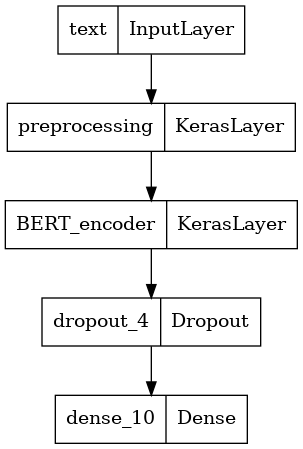

In [60]:
tf.keras.utils.plot_model(classifier_model)

In [61]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

## 训练模型

### 损失函数

我们使用交叉熵作为我们的损失函数：

$$ -\sum_{c=1}^My_{o,c}\log(p_{o,c}) $$

其中：

- M 是分类数
- y 是标签 c 在观测 o 下是否分类正确的 0/1 变量
- p 是预测概率

In [62]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

### 学习率

由于神经网络刚开始训练时非常不稳定，因此刚开始的学习率应当设置得很低很低，这样可以保证网络能够具有良好的收敛性。但是较低的学习率会使得训练过程变得非常缓慢，因此这里采用从较低学习率逐渐增大至较高学习率的方式实现网络训练前 10% 次迭代的“热身”阶段。一直使用较高学习率是不合适的，因为它会使得权重的梯度一直来回震荡，很难使训练的损失值达到全局最低谷。因此在 warm-up 结束后，我们使用线性减小的学习率。

In [63]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

### 优化器

在迁移学习时，我们选取的优化器与 BERT 在预训练时的 `Adamw` 优化器保持一致。

<img src="./figure/Adamw.png" alt="Drawing" style="width: 400px;"/>

Adam 的超收敛性质使其在训练学习率高的神经网络时可以达到节省迭代次数的效果。只要调整得当，Adam 在实践上都能达到 SGD+Momentum 的高准确率，而且速度更快。在几年前人们普遍认为 Adam 的泛化性能不如 SGD+Momentum，然而今年论文表明这通常是由于所选择的超参数不正确导致，通常来说 Adam 需要的正则化比 SGD 更多。

In [64]:
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### 开始训练

In [65]:
%%time
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
print('----- 训练开始 -----')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)
print('----- 训练完成 -----')

----- 训练开始 -----
Epoch 1/5
13/13 [==============================] - 29s 2s/step - loss: 2.5787 - binary_accuracy: 0.7365 - val_loss: 2.3920 - val_binary_accuracy: 0.8431
Epoch 2/5
13/13 [==============================] - 21s 2s/step - loss: 2.5541 - binary_accuracy: 0.8325 - val_loss: 2.3920 - val_binary_accuracy: 0.8431
Epoch 3/5
13/13 [==============================] - 21s 2s/step - loss: 2.5541 - binary_accuracy: 0.8325 - val_loss: 2.3920 - val_binary_accuracy: 0.8431
Epoch 4/5
13/13 [==============================] - 21s 2s/step - loss: 2.5541 - binary_accuracy: 0.8325 - val_loss: 2.3920 - val_binary_accuracy: 0.8431
Epoch 5/5
13/13 [==============================] - 21s 2s/step - loss: 2.5541 - binary_accuracy: 0.8325 - val_loss: 2.3920 - val_binary_accuracy: 0.8431
----- 训练完成 -----
CPU times: user 8min 17s, sys: 1min 51s, total: 10min 8s
Wall time: 1min 52s


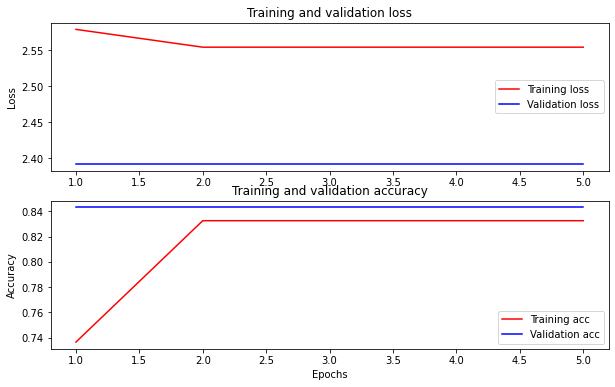

In [66]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('./figure/bert_train.png')
plt.show()

## 模型评价

我们在测试集上计算分类准确率

In [67]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 2s 416ms/step - loss: 2.6416 - binary_accuracy: 0.8268
Loss: 2.6416003704071045
Accuracy: 0.8267716765403748


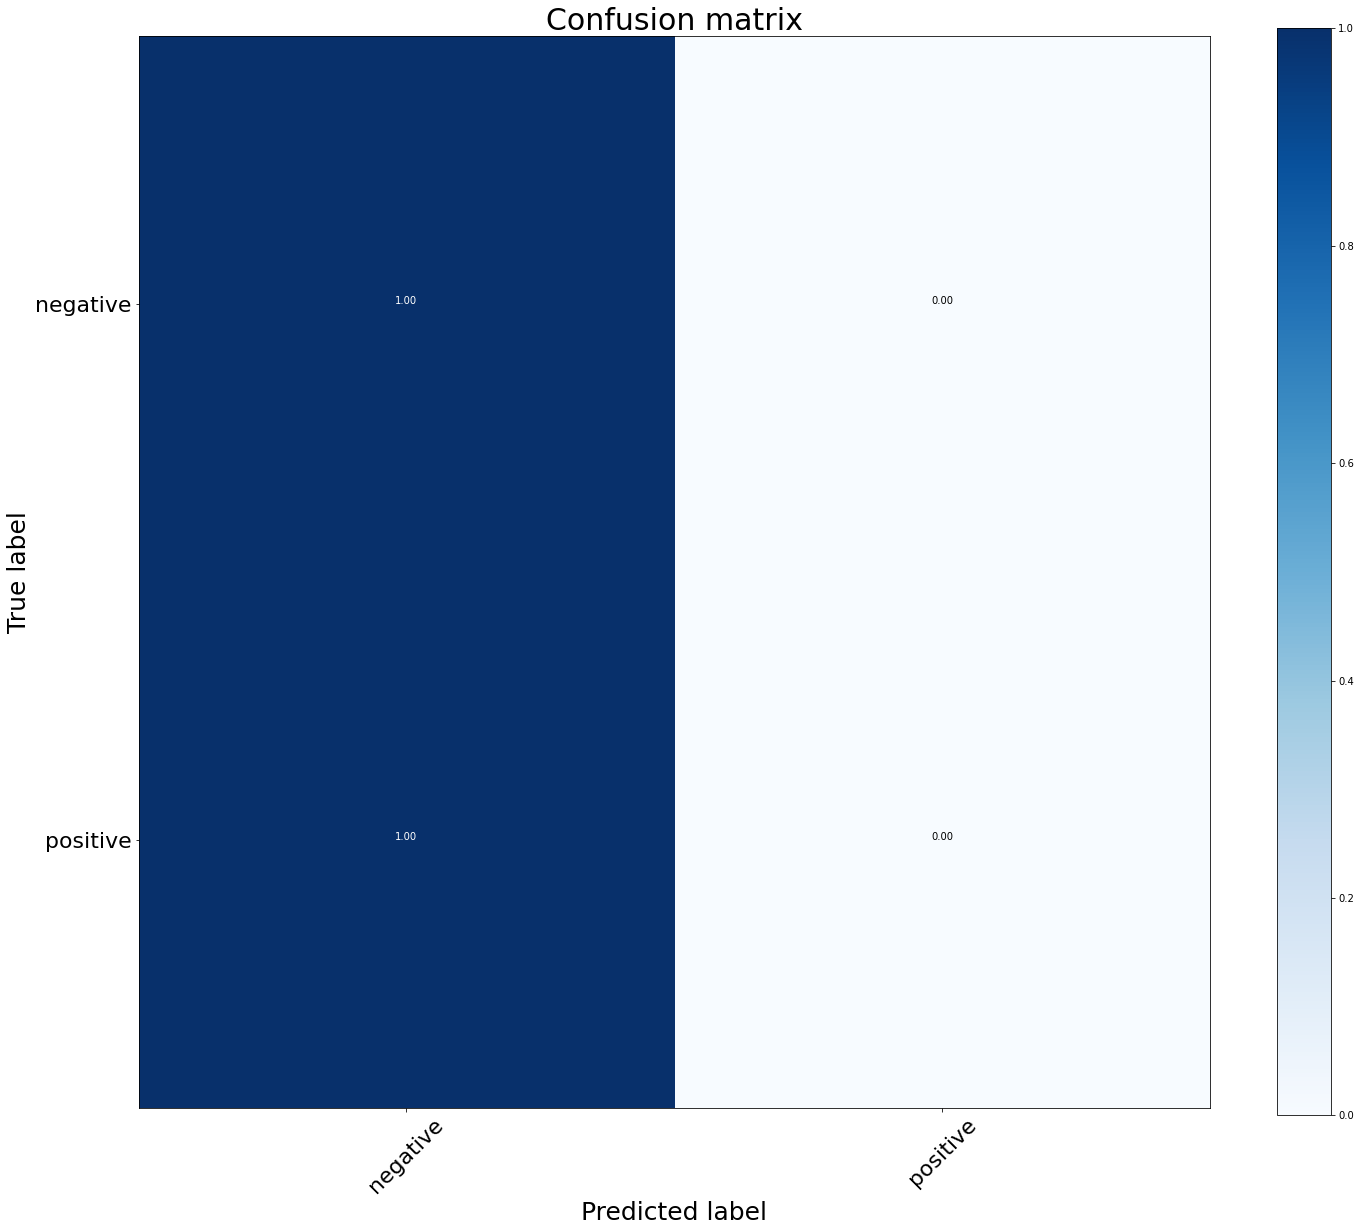

In [30]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    
predict_probability = classifier_model.predict(test_ds)
prediction = [np.argmax(i) for i in predict_probability]
cnf_matrix = confusion_matrix(y_test.tolist(), prediction)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## 模型应用

我们将经过训练完成的模型保存，方便调用。

In [31]:
classifier_model.save('./model/IMDB_bert', include_optimizer=False)

2022-01-16 19:42:57.308470: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


使用模型对输入的文本进行分类。

我们输入一则测试新闻文本：“这部电影很差劲”，该文本被模型分类为消极，符合预期。

In [32]:
model = tf.saved_model.load('./model/IMDB_bert')
query = ['This movie is so bad']
result = tf.sigmoid(model(tf.constant(query)))
print('----- 评论积极的概率 -----')
dict(zip(text_labels, result.numpy()))

----- 评论积极的概率 -----


{'negative': array([0.07201338], dtype=float32)}

# 分布式训练

> 在该笔记本中，我们演示的为并非真实的分布式，而是单机模拟的伪分布式，真实的分布式需要提交到计算机集群。

您可在该笔记本中进行代码初步测试，之后通过以下方式提交到中央财经大学高性能大数据计算集群。

* 通过 YARN 资源调度系统提交到作业队列： `spark-submit --master yarn`
* 由于在 UDF（用户自定义）函数中使用了第三方包，需要将其发送至集群中的每个计算节点 `--py-files gensim.zip`
* 队列计算完成后将结果重定向输出 `> output.txt`

## 环境启动

In [5]:
import pandas as pd
import pyspark.ml.feature
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer,Word2Vec,HashingTF
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,DecisionTreeClassifier
from pyspark.sql import SparkSession,Row
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf, col

spark = SparkSession.builder.appName('text_classification').getOrCreate()

## 数据读取

由于数据为逗号分隔的 csv 格式，在文本列出现混淆。我们使用 pandas 进行读取后再转换为 spark DataFrame 格式

In [19]:
try:
    df = spark.read.csv('./text/text.csv', header = True, inferSchema = True)
except 'FileNotFoundError':
    # location on server
    df = spark.read.csv('file:///home1/cufe/students/wuyuchong/text.csv', header = True, inferSchema = True)
df.printSchema()
df.show()

pandasDF = pd.read_csv('./text/text.csv')
pandasDF = pandasDF.query('rating != "medium"')
pandasDF['text'] = pandasDF.text.apply(lambda x: " ".join(jieba.cut(x)))
pandasDF.isnull().sum() # 缺失值检查
df = spark.createDataFrame(pandasDF)
df.show()

root
 |-- text: string (nullable = true)
 |-- rating: string (nullable = true)

+-------------------------------------+------+
|                                 text|rating|
+-------------------------------------+------+
|   对不起，我实在是无法接受这个结局。|  null|
|                                 ,bad|  null|
|从哈一到哈七。。。水平依次下降。。...|  null|
|                                 ,bad|  null|
|   这套书根本就是在宣扬扭曲的价值观吧|  null|
|                                 ,bad|  null|
|翻译太烂。和上一本一样，还比不上网...|  null|
|                                 ,bad|  null|
|                               糟透了|  null|
|                                 ,bad|  null|
|                         什么破结局！|  null|
|                                 ,bad|  null|
|        2星指翻译！翻译得还不如网上的|  null|
|                                 ,bad|  null|
|                     我很后悔买了这书|  null|
|                                 ,bad|  null|
|书越来越厚，却没有第一次拿起的心情...|  null|
|                                 ,bad|  null|
|情节不连贯，罗琳依旧采用在最后几章...|  null|
|                  

## 文本清洁

In [20]:
cleaning = True
if cleaning == False:
    df = df.withColumn("clean_text", df.text)
else:
    try:
        # 在服务器上的分布式模式中，需要使用 --py-files 将 gensim 包传到每个子节点
        # 若该过程失败则跳过文本清洁过程
        import gensim.parsing.preprocessing as gsp
        from gensim import utils
        filters = [
            gsp.strip_tags,
            gsp.strip_punctuation,
            gsp.strip_multiple_whitespaces,
            gsp.strip_numeric,
            gsp.remove_stopwords,
            gsp.strip_short,
            gsp.stem_text
        ]
        def clean_text(x):
            x = x.lower()
            x = utils.to_unicode(x)
            for f in filters:
                x = f(x)
            return x

        cleanTextUDF = udf(lambda x: clean_text(x), StringType())
        df = df.withColumn("clean_text", cleanTextUDF(col("text")))
    except:
        df = df.withColumn("clean_text", df.text)

In [21]:
# ----------------------------> 标签数字转换
labelEncoder = StringIndexer(inputCol='rating', outputCol='label').fit(df)
labelEncoder.transform(df).show(5)
df = labelEncoder.transform(df)
# ----------------------------------------------------------------------

+--------------------------------+------+---------------+-----+
|                            text|rating|     clean_text|label|
+--------------------------------+------+---------------+-----+
| 对不起 ， 我 实在 是 无法 接...|   bad|         对不起|  1.0|
| 从哈一到 哈七 。 。 。 水平 ...|   bad|从哈一到 免不了|  1.0|
|这 套书 根本就是 在 宣扬 扭曲...|   bad|根本就是 价值观|  1.0|
| 翻译 太烂 。 和 上 一本 一样...|   bad|         比不上|  1.0|
|                       糟透了 \n|   bad|         糟透了|  1.0|
+--------------------------------+------+---------------+-----+
only showing top 5 rows



## 数据集划分

划分 70% 的训练集和 30% 的测试集。

In [22]:
(trainDF,testDF) = df.randomSplit((0.7,0.3), seed=1)

## 文本特征工程

In [23]:
# ----------------------------> 特征工程方法选项
#  processType = 'word2vec'
processType = 'vectorize-idf'
#  processType = 'tf-idf'

# ----------------------------> 文本特征工程
tokenizer = Tokenizer(inputCol='clean_text', outputCol='tokens')
add_stopwords = ["<br />","amp"]
stopwords_remover = StopWordsRemover(inputCol='tokens', outputCol='filtered_tokens').setStopWords(add_stopwords)
vectorizer = CountVectorizer(inputCol='filtered_tokens', outputCol='rawFeatures')
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures")
idf = IDF(inputCol='rawFeatures', outputCol='vectorizedFeatures')
word2Vec = Word2Vec(vectorSize=50, minCount=2, inputCol="filtered_tokens", outputCol="vectorizedFeatures")
if processType == 'word2vec':
    pipeline = Pipeline(stages=[tokenizer,stopwords_remover,word2Vec])
if processType == 'vectorize-idf':
    pipeline = Pipeline(stages=[tokenizer,stopwords_remover,vectorizer,idf])
if processType == 'tf-idf':
    pipeline = Pipeline(stages=[tokenizer,stopwords_remover,hashingTF,idf])
preprocessModel = pipeline.fit(trainDF)
trainDF = preprocessModel.transform(trainDF)
testDF = preprocessModel.transform(testDF)
trainDF.show()

+-------------------------------+------+-----------------------------+-----+------------------------------+------------------------------+--------------------+--------------------+
|                           text|rating|                   clean_text|label|                        tokens|               filtered_tokens|         rawFeatures|  vectorizedFeatures|
+-------------------------------+------+-----------------------------+-----+------------------------------+------------------------------+--------------------+--------------------+
|  2 星半 ， 主角 怎么 打 都 ...|   bad|看不出 段时间 不可开交 不合理|  1.0|[看不出, 段时间, 不可开交, ...|[看不出, 段时间, 不可开交, ...|(358,[136,178,218...|(358,[136,178,218...|
|  2 星指 翻译 ！ 翻译 得 还 ...|   bad|                             |  1.0|                            []|                            []|     (358,[0],[1.0])|(358,[0],[0.74541...|
|            KJ 让 我 失望 了 \n|   bad|                             |  1.0|                            []|                            []|     (358,[0]

## 训练模型

我们首先使用简单的 logistic 模型进行拟合，在训练集上进行拟合，之后在测试集上验证模型的效果。

In [73]:
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label')
lr_model = lr.fit(trainDF)
prediction = lr_model.transform(testDF)
prediction.select(['label', 'prediction']).show()
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
accuracy = evaluator.evaluate(prediction)
print(accuracy)

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
+-----+----------+
only showing top 20 rows

0.8480392156862745


## 模型预测

我们准备了两个测试用例来验证模型是否有效。

1. 我喜欢这部电影
2. 它很差劲

模型对前一个句子的分类结果为积极，对一个句子的分类结果为消极。

In [74]:
inputText = spark.createDataFrame([("I like this movie",StringType()),
                                   ("It is so bad",StringType())],
                                  ["clean_text"])
inputText.show(truncate=False)
inputText = preprocessModel.transform(inputText)
inputPrediction = lr_model.transform(inputText)
inputPrediction.show()
inputPrediction.select(['clean_text', 'prediction']).show()

+-----------------+---+
|clean_text       |_2 |
+-----------------+---+
|I like this movie|{} |
|It is so bad     |{} |
+-----------------+---+

+-----------------+---+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+----------+
|       clean_text| _2|              tokens|     filtered_tokens|     rawFeatures|  vectorizedFeatures|       rawPrediction|         probability|prediction|
+-----------------+---+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+----------+
|I like this movie| {}|[i, like, this, m...|[i, like, this, m...|(340,[13],[1.0])|(340,[13],[4.9698...|[9.40616302147071...|[0.99991779095569...|       0.0|
|     It is so bad| {}|   [it, is, so, bad]|   [it, is, so, bad]|     (340,[],[])|         (340,[],[])|[8.77748902884587...|[0.99984585906036...|       0.0|
+-----------------+---+--------------------+--------------------+-----

## 模型比较

在 logistic 模型的基础上，我们还搭建了随机森林模型、梯度助推树模型、决策树模型。

> 此处对计算性能要求较高，请提交至集群进行计算

## 模型调参

我们使用网格搜索的方式对几个模型的超参数进行调整，选取最优的模型

# 参考文献

- [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101)
- [BBERT: Pre-training of Deep Bidirectional Transformers for Language UnderstandingERT](https://arxiv.org/abs/1810.04805)